# The battle of Neighboorhoods

### Applied Data Science Capstone

Find the best place to open a Starbucks in NYC

Author: Paola De Ros

In [43]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
import folium

from geopy.geocoders import Nominatim

import os

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported')

Libraries imported


In [41]:
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done

# All requested packages already installed.



In [3]:
CLIENT_ID = '2LGFZHBSRGVPUIAZ54XLHCXAKDVJEY1KFK5XKIVTYP1VWRRH' 
CLIENT_SECRET = 'ZW2EYTDDLJZACFJMENWF12RQK4KVGKU5TLNPH5F3ZMFTTPPS' 
VERSION = '20180605'

In [4]:
def geo_location(address):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

def get_venues(lat,lng):
    radius=400
    LIMIT=100
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

def get_venue_details(venue_id):
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    features=resp['features']
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [5]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [6]:
ny_data.shape

(306, 4)

The total number of neighboorhoods in NYC is 306

## Data Analysis

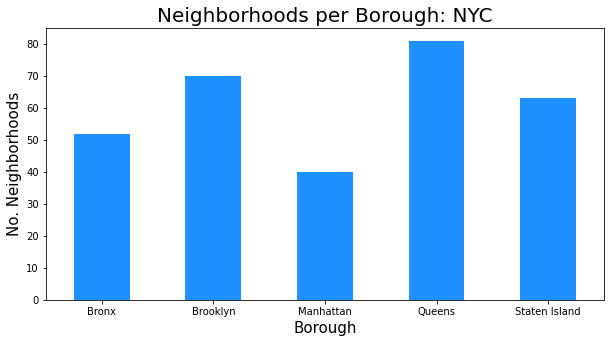

In [35]:
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color="dodgerblue" ) 
plt.title('Neighborhoods per Borough: NYC', fontsize = 20) 
plt.xlabel('Borough', fontsize = 15) 
plt.ylabel('No. Neighborhoods',fontsize = 15) 
plt.xticks(rotation = 'horizontal')
plt.show()

The borough that has more neighboorhoods is Queens

In [8]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_restaurants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(ny_data),')','Chinese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(chinese_restaurants)))
    print(row)
    for resturant_detail in chinese_restaurants.values.tolist():
        id, name , category=resturant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Chinese Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Chinese Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Chinese Restaurants in Eastchester, Bronx:1
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Chinese Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Chinese Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Chinese Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Chinese Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Chinese Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Chinese Restaurants in Norwood, Bronx:0
['

( 68 / 306 ) Chinese Restaurants in Red Hook, Brooklyn:0
['Brooklyn', 'Red Hook', 40.676253230250886, -74.0127589747356]
( 69 / 306 ) Chinese Restaurants in Gowanus, Brooklyn:1
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) Chinese Restaurants in Fort Greene, Brooklyn:0
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Chinese Restaurants in Park Slope, Brooklyn:1
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Chinese Restaurants in Cypress Hills, Brooklyn:1
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Chinese Restaurants in East New York, Brooklyn:1
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Chinese Restaurants in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]
( 75 / 306 ) Chinese Restaurants in Canarsie, Brooklyn:0
['Brooklyn', 'Canarsie', 40.63556432797428, -73.90209269

( 131 / 306 ) Chinese Restaurants in Woodside, Queens:1
['Queens', 'Woodside', 40.74634908860222, -73.90184166838284]
( 132 / 306 ) Chinese Restaurants in Jackson Heights, Queens:0
['Queens', 'Jackson Heights', 40.75198138007367, -73.88282109164365]
( 133 / 306 ) Chinese Restaurants in Elmhurst, Queens:2
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 134 / 306 ) Chinese Restaurants in Howard Beach, Queens:1
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 135 / 306 ) Chinese Restaurants in Corona, Queens:2
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 136 / 306 ) Chinese Restaurants in Forest Hills, Queens:1
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
( 137 / 306 ) Chinese Restaurants in Kew Gardens, Queens:2
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
( 138 / 306 ) Chinese Restaurants in Richmond Hill, Queens:0
['Queens', 'Richmond Hill', 40.69794731471763, -73.83183321446887]
( 139 / 306 ) C

( 198 / 306 ) Chinese Restaurants in St. George, Staten Island:0
['Staten Island', 'St. George', 40.6449815710044, -74.07935312512797]
( 199 / 306 ) Chinese Restaurants in New Brighton, Staten Island:0
['Staten Island', 'New Brighton', 40.64061455913511, -74.08701650516625]
( 200 / 306 ) Chinese Restaurants in Stapleton, Staten Island:1
['Staten Island', 'Stapleton', 40.62692762538176, -74.07790192660066]
( 201 / 306 ) Chinese Restaurants in Rosebank, Staten Island:0
['Staten Island', 'Rosebank', 40.61530494652761, -74.06980526716141]
( 202 / 306 ) Chinese Restaurants in West Brighton, Staten Island:0
['Staten Island', 'West Brighton', 40.63187892654607, -74.1071817826561]
( 203 / 306 ) Chinese Restaurants in Grymes Hill, Staten Island:0
['Staten Island', 'Grymes Hill', 40.624184791313006, -74.08724819983729]
( 204 / 306 ) Chinese Restaurants in Todt Hill, Staten Island:0
['Staten Island', 'Todt Hill', 40.59706851814673, -74.1113288180088]
( 205 / 306 ) Chinese Restaurants in South Bea

( 259 / 306 ) Chinese Restaurants in Elm Park, Staten Island:1
['Staten Island', 'Elm Park', 40.630146741193826, -74.1418167896889]
( 260 / 306 ) Chinese Restaurants in Remsen Village, Brooklyn:0
['Brooklyn', 'Remsen Village', 40.652117451793494, -73.91665331978048]
( 261 / 306 ) Chinese Restaurants in New Lots, Brooklyn:2
['Brooklyn', 'New Lots', 40.6627442796966, -73.88511776379292]
( 262 / 306 ) Chinese Restaurants in Paerdegat Basin, Brooklyn:0
['Brooklyn', 'Paerdegat Basin', 40.63131755039667, -73.90233474295836]
( 263 / 306 ) Chinese Restaurants in Mill Basin, Brooklyn:1
['Brooklyn', 'Mill Basin', 40.61597423962336, -73.91515391550404]
( 264 / 306 ) Chinese Restaurants in Jamaica Hills, Queens:2
['Queens', 'Jamaica Hills', 40.71145964370482, -73.79646462081593]
( 265 / 306 ) Chinese Restaurants in Utopia, Queens:0
['Queens', 'Utopia', 40.73350025429757, -73.79671678028349]
( 266 / 306 ) Chinese Restaurants in Pomonok, Queens:1
['Queens', 'Pomonok', 40.73493618075478, -73.80486120

In [9]:
chinese_rest_ny.to_csv('chinese_rest_ny_tocsv1.csv')

In [10]:
chinese_ny = pd.read_csv('chinese_rest_ny_tocsv1.csv')
chinese_rest_ny.tail()

,Borough,Neighborhood,ID,Name
175,Brooklyn,Homecrest,514645bae4b0238f38bcdbac,Season Restaurant
176,Staten Island,Prince's Bay,4bb7d282b35776b0b83dc801,Island Taste
177,Bronx,Allerton,4c7dbf7f10916dcba78e2a96,Chef King
178,Bronx,Kingsbridge Heights,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant
179,Brooklyn,Erasmus,4e10c87122713f7d7bcb9d1d,Kam Man Chinese Food


In [11]:
chinese_rest_ny.shape

(180, 4)

There are 180 Chinese restaurants in NYC

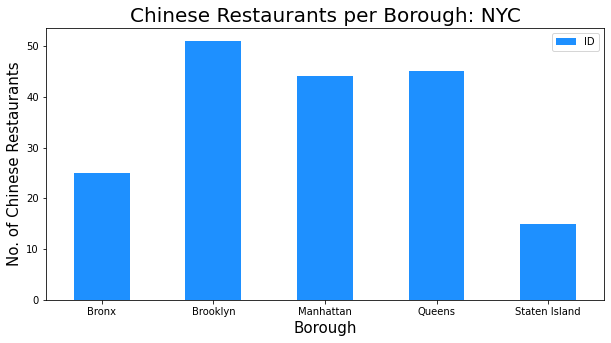

In [12]:
chinese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color='dodgerblue')
plt.title('Chinese Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Chinese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

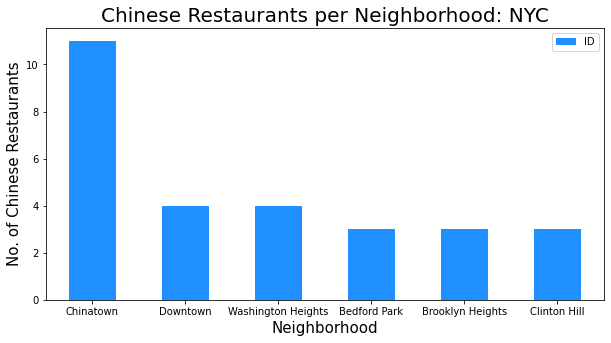

In [14]:
NOofNeigh = 6
chinese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color='dodgerblue')
plt.title('Chinese Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Chinese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [15]:
chinese_rest_ny[chinese_rest_ny['Neighborhood']=='Chinatown']

,Borough,Neighborhood,ID,Name
60,Manhattan,Chinatown,4db3374590a0843f295fb69b,Spicy Village
61,Manhattan,Chinatown,4a96bf8ff964a520ce2620e3,Wah Fung Number 1 Fast Food 華豐快餐店
62,Manhattan,Chinatown,5894c9a15e56b417cf79e553,Xi'an Famous Foods
63,Manhattan,Chinatown,3fd66200f964a520b1ea1ee3,Great N.Y. Noodletown
64,Manhattan,Chinatown,59d828f0916bc1155fde2c04,Hwa Yuan
65,Manhattan,Chinatown,5c965dad5455b2002c058659,Yi Ji Shi Mo Noodle Corp
66,Manhattan,Chinatown,4afff2b4f964a520583a22e3,Sun Hing Lung Ho Fun Tofu
67,Manhattan,Chinatown,4bc34a294cdfc9b6a01a9721,Happy Cafe (Happy Express Cafe)
68,Manhattan,Chinatown,5ff9e5215b3abd71536c9b46,Hay Hay Roasted 囍燒臘
69,Manhattan,Chinatown,3fd66200f964a520ceea1ee3,Deluxe Green Bo Restaurant


Chinatown in Manhattan has the highest number of Chinese Restaurants with a total count of 11

#### Ranking Analysis

In [20]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in chinese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(chinese_rest_ny),')','processed')
    chinese_rest_stats_ny = chinese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
chinese_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '61499198b7b31a07c5cf0e6d'}, 'response': {'venue': {'id': '4dabc3dc93a04642f09ccabd', 'name': 'Xing Lung Chinese Restaurant', 'contact': {'phone': '7183241014', 'formattedPhone': '(718) 324-1014'}, 'location': {'address': '3828 B Dyre Ave', 'crossStreet': 'E 233 St', 'lat': 40.8887854684858, 'lng': -73.83122576835156, 'labeledLatLngs': [{'label': 'display', 'lat': 40.8887854684858, 'lng': -73.83122576835156}], 'postalCode': '10466', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3828 B Dyre Ave (E 233 St)', 'Bronx, NY 10466', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xing-lung-chinese-restaurant/4dabc3dc93a04642f09ccabd', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': Fals

{'meta': {'code': 200, 'requestId': '614991998bfb314157bb0eff'}, 'response': {'venue': {'id': '4e4d0387bd413c4cc66dfd72', 'name': 'Hung Hing Chinese Restaurant', 'contact': {'phone': '7185625050', 'formattedPhone': '(718) 562-5050'}, 'location': {'address': '239 Bedford Park Blvd', 'lat': 40.871181206606806, 'lng': -73.88675855253665, 'labeledLatLngs': [{'label': 'display', 'lat': 40.871181206606806, 'lng': -73.88675855253665}, {'label': 'entrance', 'lat': 40.871189, 'lng': -73.886476}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['239 Bedford Park Blvd', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hung-hing-chinese-restaurant/4e4d0387bd413c4cc66dfd72', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'

{'meta': {'code': 200, 'requestId': '614991991ea9d165bc002e19'}, 'response': {'venue': {'id': '4d081644e554721e5423c0f8', 'name': 'Wai Kang Kitchen Chinese Food', 'contact': {'phone': '7189332797', 'formattedPhone': '(718) 933-2797'}, 'location': {'address': '39 Bedford Park Blvd W', 'crossStreet': 'Grand concourse', 'lat': 40.8726151696897, 'lng': -73.88842540381232, 'labeledLatLngs': [{'label': 'display', 'lat': 40.8726151696897, 'lng': -73.88842540381232}], 'postalCode': '10468', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['39 Bedford Park Blvd W (Grand concourse)', 'Bronx, NY 10468', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wai-kang-kitchen-chinese-food/4d081644e554721e5423c0f8', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'prim

{'meta': {'code': 200, 'requestId': '6149919aecb6c73354b5bb7b'}, 'response': {'venue': {'id': '4d2d1728762fa143051f7664', 'name': 'Dong King', 'contact': {}, 'location': {'address': '80 W 165th St', 'lat': 40.833692, 'lng': -73.92746600000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.833692, 'lng': -73.92746600000001}, {'label': 'entrance', 'lat': 40.833888, 'lng': -73.927236}], 'postalCode': '10452', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['80 W 165th St', 'Bronx, NY 10452', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dong-king/4d2d1728762fa143051f7664', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'li

{'meta': {'code': 200, 'requestId': '6149919b87e2b3504b3b1f89'}, 'response': {'venue': {'id': '4e656e8252b1260c14683b4b', 'name': 'Kee Hing Restaurant', 'contact': {'phone': '7189911105', 'formattedPhone': '(718) 991-1105'}, 'location': {'address': '845 Soundview Ave', 'crossStreet': 'Story Ave.', 'lat': 40.822140999999995, 'lng': -73.8677, 'labeledLatLngs': [{'label': 'display', 'lat': 40.822140999999995, 'lng': -73.8677}, {'label': 'entrance', 'lat': 40.822374, 'lng': -73.867704}], 'postalCode': '10473', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['845 Soundview Ave (Story Ave.)', 'Bronx, NY 10473', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kee-hing-restaurant/4e656e8252b1260c14683b4b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, '

                         ID                             Name  Likes  Rating  \
0  4b89b62df964a520ff4c32e3  Sabor Latino Seafood Restaurant      5     6.7   

   Tips  
0     8  
( 14 / 180 ) processed
{'meta': {'code': 200, 'requestId': '6149919b9aa54e098d6afa62'}, 'response': {'venue': {'id': '4c7d29b2d598a09354f6c162', 'name': 'Happy Garden', 'contact': {'phone': '7184091471', 'formattedPhone': '(718) 409-1471'}, 'location': {'address': '706 Morris Park Ave', 'crossStreet': 'White plains rd', 'lat': 40.84506, 'lng': -73.865557, 'labeledLatLngs': [{'label': 'display', 'lat': 40.84506, 'lng': -73.865557}, {'label': 'entrance', 'lat': 40.845184, 'lng': -73.865597}], 'postalCode': '10462', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['706 Morris Park Ave (White plains rd)', 'Bronx, NY 10462', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/happy-garden/4c7d29b2d598a09354f6c162', 'categories': [{'id': '4bf58dd8d48988d145941735'

{'meta': {'code': 200, 'requestId': '6149919cb7330273758fa3bf'}, 'response': {'venue': {'id': '4ca4fda4d971b1f77da5f2e0', 'name': 'Golden Phoenix Chinese Restaurant', 'contact': {'phone': '7185488888', 'formattedPhone': '(718) 548-8888'}, 'location': {'address': '5646 Riverdale Ave', 'crossStreet': 'West 258th Street', 'lat': 40.90568876262962, 'lng': -73.90429772559949, 'labeledLatLngs': [{'label': 'display', 'lat': 40.90568876262962, 'lng': -73.90429772559949}, {'label': 'entrance', 'lat': 40.905658, 'lng': -73.90424}], 'postalCode': '10471', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5646 Riverdale Ave (West 258th Street)', 'Bronx, NY 10471', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/golden-phoenix-chinese-restaurant/4ca4fda4d971b1f77da5f2e0', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.

{'meta': {'code': 200, 'requestId': '6149919c1ea9d165bc00345a'}, 'response': {'venue': {'id': '4d9a695ee5fd6ea8e3096df5', 'name': 'Lucky House Chinese Restaurant', 'contact': {'phone': '7186817430', 'formattedPhone': '(718) 681-7430'}, 'location': {'address': '202 E 167th St', 'lat': 40.83393302779995, 'lng': -73.91667401417777, 'labeledLatLngs': [{'label': 'display', 'lat': 40.83393302779995, 'lng': -73.91667401417777}, {'label': 'entrance', 'lat': 40.833882, 'lng': -73.916574}], 'postalCode': '10456', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['202 E 167th St', 'Bronx, NY 10456', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lucky-house-chinese-restaurant/4d9a695ee5fd6ea8e3096df5', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary'

{'meta': {'code': 200, 'requestId': '6149919d6a98015b73072218'}, 'response': {'venue': {'id': '5553702c498ecb85f99d8f37', 'name': 'XIN', 'contact': {'phone': '3476626222', 'formattedPhone': '(347) 662-6222', 'twitter': 'xinbayridge'}, 'location': {'address': '8320 3rd Ave', 'lat': 40.62508203621133, 'lng': -74.0304936920825, 'labeledLatLngs': [{'label': 'display', 'lat': 40.62508203621133, 'lng': -74.0304936920825}, {'label': 'entrance', 'lat': 40.625159, 'lng': -74.030522}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8320 3rd Ave', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xin/5553702c498ecb85f99d8f37', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False,

{'meta': {'code': 200, 'requestId': '6149919d0d9b781a98c74768'}, 'response': {'venue': {'id': '4bd60f4c4e32d13a6000c280', 'name': 'Taste Of China', 'contact': {'phone': '7182563838', 'formattedPhone': '(718) 256-3838'}, 'location': {'address': '7824 20th Ave', 'crossStreet': 'at 79th St.', 'lat': 40.608834, 'lng': -73.994117, 'labeledLatLngs': [{'label': 'display', 'lat': 40.608834, 'lng': -73.994117}, {'label': 'entrance', 'lat': 40.608729, 'lng': -73.99415}], 'postalCode': '11214', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['7824 20th Ave (at 79th St.)', 'Brooklyn, NY 11214', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/taste-of-china/4bd60f4c4e32d13a6000c280', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verifi

{'meta': {'code': 200, 'requestId': '6149919e0d9b781a98c74892'}, 'response': {'venue': {'id': '4da63c757ccc816e30f2b87b', 'name': 'Grand Fortune Chinese Take Out', 'contact': {'phone': '7182668482', 'formattedPhone': '(718) 266-8482'}, 'location': {'address': '202 Avenue U', 'crossStreet': 'W 5th St', 'lat': 40.596379, 'lng': -73.976672, 'labeledLatLngs': [{'label': 'display', 'lat': 40.596379, 'lng': -73.976672}, {'label': 'entrance', 'lat': 40.596483, 'lng': -73.976698}], 'postalCode': '11223', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['202 Avenue U (W 5th St)', 'Brooklyn, NY 11223', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/grand-fortune-chinese-take-out/4da63c757ccc816e30f2b87b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, '

{'meta': {'code': 200, 'requestId': '6149919e18679335cb9c802f'}, 'response': {'venue': {'id': '4c6b208e0c3ac9b6be76d138', 'name': 'China Express', 'contact': {'phone': '7184622778', 'formattedPhone': '(718) 462-2778'}, 'location': {'address': '4106 Avenue D', 'lat': 40.641422, 'lng': -73.937668, 'labeledLatLngs': [{'label': 'display', 'lat': 40.641422, 'lng': -73.937668}, {'label': 'entrance', 'lat': 40.641507, 'lng': -73.937678}], 'postalCode': '11203', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4106 Avenue D', 'Brooklyn, NY 11203', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/china-express/4c6b208e0c3ac9b6be76d138', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'url': 

{'meta': {'code': 200, 'requestId': '6149919fc4e3ae382cff8645'}, 'response': {'venue': {'id': '54e39b14498e9c646b42958e', 'name': 'East Wind Snack Shop', 'contact': {'phone': '9292950188', 'formattedPhone': '(929) 295-0188'}, 'location': {'address': '471 16th St', 'crossStreet': 'at Prospect Park West', 'lat': 40.660297, 'lng': -73.980169, 'labeledLatLngs': [{'label': 'display', 'lat': 40.660297, 'lng': -73.980169}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['471 16th St (at Prospect Park West)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/east-wind-snack-shop/54e39b14498e9c646b42958e', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount

                         ID                    Name  Likes  Rating  Tips
0  4c06e2470e0a2d7fdf8aec0c  #1 Garden Chinese Food      5     6.5     4
( 32 / 180 ) processed
{'meta': {'code': 200, 'requestId': '6149919f1ea9d165bc003993'}, 'response': {'venue': {'id': '4c38b7421e06d13acf3c783e', 'name': 'Wah Yung Chinese Food', 'contact': {}, 'location': {'address': '648 Rockaway Ave', 'crossStreet': 'Dumont Avenue', 'lat': 40.664266999999995, 'lng': -73.909533, 'labeledLatLngs': [{'label': 'display', 'lat': 40.664266999999995, 'lng': -73.909533}, {'label': 'entrance', 'lat': 40.664237, 'lng': -73.909482}], 'postalCode': '11212', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['648 Rockaway Ave (Dumont Avenue)', 'Brooklyn, NY 11212', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wah-yung-chinese-food/4c38b7421e06d13acf3c783e', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese R

( 34 / 180 ) processed
{'meta': {'code': 200, 'requestId': '614991a0cba5ad65035b0e42'}, 'response': {'venue': {'id': '4a9ac078f964a5207c3220e3', 'name': 'Fortune House', 'contact': {'phone': '7188557055', 'formattedPhone': '(718) 855-7055'}, 'location': {'address': '82 Henry St', 'crossStreet': 'btwn Pineapple & Orange St', 'lat': 40.698411434008214, 'lng': -73.99254201285272, 'labeledLatLngs': [{'label': 'display', 'lat': 40.698411434008214, 'lng': -73.99254201285272}, {'label': 'entrance', 'lat': 40.69842, 'lng': -73.992688}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['82 Henry St (btwn Pineapple & Orange St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fortune-house/4a9ac078f964a5207c3220e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.

{'meta': {'code': 200, 'requestId': '614991a0b2f11829e4a5a22b'}, 'response': {'venue': {'id': '4a986a9cf964a520e82b20e3', 'name': 'Great Wall Chinese Food', 'contact': {'phone': '7188552630', 'formattedPhone': '(718) 855-2630'}, 'location': {'address': '60 Henry St', 'crossStreet': 'btw Cranberry St and Orange St', 'lat': 40.698983696296274, 'lng': -73.99218529980111, 'labeledLatLngs': [{'label': 'display', 'lat': 40.698983696296274, 'lng': -73.99218529980111}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['60 Henry St (btw Cranberry St and Orange St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/great-wall-chinese-food/4a986a9cf964a520e82b20e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'},

( 38 / 180 ) processed
{'meta': {'code': 200, 'requestId': '614991a1ecb6c73354b5c814'}, 'response': {'venue': {'id': '4c60a7cede6920a15f9d9664', 'name': "Michael and Ping's", 'contact': {'phone': '7187880017', 'formattedPhone': '(718) 788-0017', 'facebook': '107321149195', 'facebookUsername': 'michaelandpings', 'facebookName': "Michael & Ping's - Modern Chinese Take-out"}, 'location': {'address': '437 3rd Ave', 'crossStreet': 'btwn 7th & 8th St.', 'lat': 40.67216239483681, 'lng': -73.99037941409061, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67216239483681, 'lng': -73.99037941409061}, {'label': 'entrance', 'lat': 40.67216, 'lng': -73.990273}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['437 3rd Ave (btwn 7th & 8th St.)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/michael-and-pings/4c60a7cede6920a15f9d9664', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 

{'meta': {'code': 200, 'requestId': '614991a171c6475ac93f4b49'}, 'response': {'venue': {'id': '49bb541ff964a520e3531fe3', 'name': 'Hunan Delight', 'contact': {'phone': '7187891400', 'formattedPhone': '(718) 789-1400'}, 'location': {'address': '752 Union St', 'crossStreet': 'b/t 5th and 6th ave', 'lat': 40.67546106658002, 'lng': -73.97804145177376, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67546106658002, 'lng': -73.97804145177376}, {'label': 'entrance', 'lat': 40.675398, 'lng': -73.978171}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['752 Union St (b/t 5th and 6th ave)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hunan-delight/49bb541ff964a520e3531fe3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 

{'meta': {'code': 200, 'requestId': '614991a18bfb314157bb1ed3'}, 'response': {'venue': {'id': '4dd1b576c65b9d071f8c6ac1', 'name': 'Golden Horse Restaurant', 'contact': {'phone': '7186491809', 'formattedPhone': '(718) 649-1809'}, 'location': {'address': '792 New Lots Ave', 'crossStreet': 'Elton Ave', 'lat': 40.666676, 'lng': -73.881236, 'labeledLatLngs': [{'label': 'display', 'lat': 40.666676, 'lng': -73.881236}, {'label': 'entrance', 'lat': 40.666849, 'lng': -73.881326}], 'postalCode': '11208', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['792 New Lots Ave (Elton Ave)', 'Brooklyn, NY 11208', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/golden-horse-restaurant/4dd1b576c65b9d071f8c6ac1', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'prim

{'meta': {'code': 200, 'requestId': '614991a24f622b6600272149'}, 'response': {'venue': {'id': '5b401f5c67f62b002c1e7fb7', 'name': 'JJ Kitchen', 'contact': {}, 'location': {'address': '475 Myrtle Ave', 'crossStreet': 'Hall', 'lat': 40.69361114501953, 'lng': -73.96626281738281, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69361114501953, 'lng': -73.96626281738281}], 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['475 Myrtle Ave (Hall)', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jj-kitchen/5b401f5c67f62b002c1e7fb7', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'url': 'https://www.asiancuisinefl.com/#', 'price': {'tier': 1, 'm

{'meta': {'code': 200, 'requestId': '614991a34f622b660027227d'}, 'response': {'venue': {'id': '585d72449f25836f2b2b7a1b', 'name': 'Xifu Food', 'contact': {'phone': '7182378886', 'formattedPhone': '(718) 237-8886'}, 'location': {'address': '318 Livingston St', 'lat': 40.688027, 'lng': -73.982088, 'labeledLatLngs': [{'label': 'display', 'lat': 40.688027, 'lng': -73.982088}, {'label': 'entrance', 'lat': 40.688057, 'lng': -73.982014}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['318 Livingston St', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xifu-food/585d72449f25836f2b2b7a1b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d108941735', 'name': 'Dumpling 

{'meta': {'code': 200, 'requestId': '614991a3b2373b186974f707'}, 'response': {'venue': {'id': '585d72449f25836f2b2b7a1b', 'name': 'Xifu Food', 'contact': {'phone': '7182378886', 'formattedPhone': '(718) 237-8886'}, 'location': {'address': '318 Livingston St', 'lat': 40.688027, 'lng': -73.982088, 'labeledLatLngs': [{'label': 'display', 'lat': 40.688027, 'lng': -73.982088}, {'label': 'entrance', 'lat': 40.688057, 'lng': -73.982014}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['318 Livingston St', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xifu-food/585d72449f25836f2b2b7a1b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d108941735', 'name': 'Dumpling 

{'meta': {'code': 200, 'requestId': '614991a38bfb314157bb2316'}, 'response': {'venue': {'id': '4e4cde0cbd413c4cc66cceeb', 'name': 'Panda House Chinese Restaurant', 'contact': {'phone': '7182777700', 'formattedPhone': '(718) 277-7700'}, 'location': {'address': '530 Conduit Blvd', 'lat': 40.676716, 'lng': -73.869783, 'labeledLatLngs': [{'label': 'display', 'lat': 40.676716, 'lng': -73.869783}], 'postalCode': '11208', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['530 Conduit Blvd', 'Brooklyn, NY 11208', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/panda-house-chinese-restaurant/4e4cde0cbd413c4cc66cceeb', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'messa

{'meta': {'code': 200, 'requestId': '614991a41d9c4336e5c08363'}, 'response': {'venue': {'id': '3fd66200f964a5206bf11ee3', 'name': 'M Shanghai Bistro', 'contact': {'phone': '7183849300', 'formattedPhone': '(718) 384-9300', 'twitter': 'm_shanghai'}, 'location': {'address': '292 Grand St', 'crossStreet': 'btwn Roebling St & Havemeyer St', 'lat': 40.71302151768249, 'lng': -73.95752069380897, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71302151768249, 'lng': -73.95752069380897}, {'label': 'entrance', 'lat': 40.712937, 'lng': -73.957563}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['292 Grand St (btwn Roebling St & Havemeyer St)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/m-shanghai-bistro/3fd66200f964a5206bf11ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix

{'meta': {'code': 200, 'requestId': '614991a4e08d6b510cdba5d1'}, 'response': {'venue': {'id': '3fd66200f964a5206bf11ee3', 'name': 'M Shanghai Bistro', 'contact': {'phone': '7183849300', 'formattedPhone': '(718) 384-9300', 'twitter': 'm_shanghai'}, 'location': {'address': '292 Grand St', 'crossStreet': 'btwn Roebling St & Havemeyer St', 'lat': 40.71302151768249, 'lng': -73.95752069380897, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71302151768249, 'lng': -73.95752069380897}, {'label': 'entrance', 'lat': 40.712937, 'lng': -73.957563}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['292 Grand St (btwn Roebling St & Havemeyer St)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/m-shanghai-bistro/3fd66200f964a5206bf11ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix

{'meta': {'code': 200, 'requestId': '614991a44a9e6c2a01978f05'}, 'response': {'venue': {'id': '54b318a1498eb29e9541053a', 'name': 'Wei Williamsburg', 'contact': {'phone': '7183601908', 'formattedPhone': '(718) 360-1908', 'twitter': 'williamsburgwei'}, 'location': {'address': '145 Borinquen Pl', 'crossStreet': 'Keap Street', 'lat': 40.71067589705568, 'lng': -73.95403239442538, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71067589705568, 'lng': -73.95403239442538}, {'label': 'entrance', 'lat': 40.710819, 'lng': -73.953903}], 'postalCode': '11211', 'cc': 'US', 'neighborhood': 'South Williamsburg', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['145 Borinquen Pl (Keap Street)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wei-williamsburg/54b318a1498eb29e9541053a', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon':

{'meta': {'code': 200, 'requestId': '614991a59aa54e098d6b0be7'}, 'response': {'venue': {'id': '4b512cbaf964a520f64527e3', 'name': 'ha ha chinese', 'contact': {'phone': '7188338078', 'formattedPhone': '(718) 833-8078'}, 'location': {'address': '9212 4th Ave', 'crossStreet': '92nd + 93rd and 4th ave', 'lat': 40.618022230237116, 'lng': -74.03030968368607, 'labeledLatLngs': [{'label': 'display', 'lat': 40.618022230237116, 'lng': -74.03030968368607}, {'label': 'entrance', 'lat': 40.618092, 'lng': -74.030468}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9212 4th Ave (92nd + 93rd and 4th ave)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ha-ha-chinese/4b512cbaf964a520f64527e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food

{'meta': {'code': 200, 'requestId': '614991a55f8a5d416d9b4886'}, 'response': {'venue': {'id': '4cb0fb23eb65b1f7c61871cd', 'name': 'Panda Garden', 'contact': {'phone': '7186801126', 'formattedPhone': '(718) 680-1126'}, 'location': {'address': '9708 3rd Ave', 'lat': 40.615772172484405, 'lng': -74.03427146686259, 'labeledLatLngs': [{'label': 'display', 'lat': 40.615772172484405, 'lng': -74.03427146686259}, {'label': 'entrance', 'lat': 40.615751, 'lng': -74.034365}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9708 3rd Ave', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/panda-garden/4cb0fb23eb65b1f7c61871cd', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'st

{'meta': {'code': 200, 'requestId': '614991a50d9b781a98c756b4'}, 'response': {'venue': {'id': '4a96bf8ff964a520ce2620e3', 'name': 'Wah Fung Number 1 Fast Food 華豐快餐店', 'contact': {'phone': '2129255175', 'formattedPhone': '(212) 925-5175'}, 'location': {'address': '79 Chrystie St', 'crossStreet': 'btwn Hester St & Grand St', 'lat': 40.71727831655619, 'lng': -73.99417731304892, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71727831655619, 'lng': -73.99417731304892}, {'label': 'entrance', 'lat': 40.717303, 'lng': -73.994439}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['79 Chrystie St (btwn Hester St & Grand St)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wah-fung-number-1-fast-food-%E8%8F%AF%E8%B1%90%E5%BF%AB%E9%A4%90%E5%BA%97/4a96bf8ff964a520ce2620e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', '

{'meta': {'code': 200, 'requestId': '614991a6b2373b186974fbcf'}, 'response': {'venue': {'id': '5894c9a15e56b417cf79e553', 'name': "Xi'an Famous Foods", 'contact': {'twitter': 'xianfoods', 'facebook': '90354836008', 'facebookUsername': 'xianfoods', 'facebookName': "Xi'an Famous Foods 西安名吃"}, 'location': {'address': '45 Bayard St', 'crossStreet': 'Bowery', 'lat': 40.715231941715004, 'lng': -73.99726288220869, 'labeledLatLngs': [{'label': 'display', 'lat': 40.715231941715004, 'lng': -73.99726288220869}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['45 Bayard St (Bowery)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xian-famous-foods/5894c9a15e56b417cf79e553', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix

{'meta': {'code': 200, 'requestId': '614991a6b7b31a07c5cf2871'}, 'response': {'venue': {'id': '3fd66200f964a520b1ea1ee3', 'name': 'Great N.Y. Noodletown', 'contact': {'phone': '2123490923', 'formattedPhone': '(212) 349-0923'}, 'location': {'address': '28 Bowery', 'crossStreet': 'btwn Pell & Bayard St', 'lat': 40.715039001656855, 'lng': -73.99694075378208, 'labeledLatLngs': [{'label': 'display', 'lat': 40.715039001656855, 'lng': -73.99694075378208}, {'label': 'entrance', 'lat': 40.714988, 'lng': -73.997055}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['28 Bowery (btwn Pell & Bayard St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/great-ny-noodletown/3fd66200f964a520b1ea1ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/

( 65 / 180 ) processed
{'meta': {'code': 200, 'requestId': '614991a6b2373b186974fce3'}, 'response': {'venue': {'id': '5c965dad5455b2002c058659', 'name': 'Yi Ji Shi Mo Noodle Corp', 'contact': {'phone': '6462336311', 'formattedPhone': '(646) 233-6311'}, 'location': {'address': '88 Elizabeth St', 'crossStreet': 'btwn Hester & Grand St', 'lat': 40.7182541242483, 'lng': -73.99593030303214, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7182541242483, 'lng': -73.99593030303214}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['88 Elizabeth St (btwn Hester & Grand St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yi-ji-shi-mo-noodle-corp/5c965dad5455b2002c058659', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suff

{'meta': {'code': 200, 'requestId': '614991a7298f5e1b75c5b7e2'}, 'response': {'venue': {'id': '4afff2b4f964a520583a22e3', 'name': 'Sun Hing Lung Ho Fun Tofu', 'contact': {'phone': '2129627032', 'formattedPhone': '(212) 962-7032'}, 'location': {'address': '58 Henry St', 'crossStreet': 'Market', 'lat': 40.71296798032269, 'lng': -73.99514878725047, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71296798032269, 'lng': -73.99514878725047}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['58 Henry St (Market)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sun-hing-lung-ho-fun-tofu/4afff2b4f964a520583a22e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats'

{'meta': {'code': 200, 'requestId': '614991a71121e71542c1975b'}, 'response': {'venue': {'id': '4bc34a294cdfc9b6a01a9721', 'name': 'Happy Cafe (Happy Express Cafe)', 'contact': {'phone': '2129659898', 'formattedPhone': '(212) 965-9898'}, 'location': {'address': '6 Allen St', 'crossStreet': 'Canal St', 'lat': 40.714694991263045, 'lng': -73.99267202150516, 'labeledLatLngs': [{'label': 'display', 'lat': 40.714694991263045, 'lng': -73.99267202150516}, {'label': 'entrance', 'lat': 40.714688, 'lng': -73.992436}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['6 Allen St (Canal St)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/happy-cafe/4bc34a294cdfc9b6a01a9721', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix':

{'meta': {'code': 200, 'requestId': '614991a794006d1f5bf3ff3e'}, 'response': {'venue': {'id': '3fd66200f964a520ceea1ee3', 'name': 'Deluxe Green Bo Restaurant', 'contact': {'phone': '2126252359', 'formattedPhone': '(212) 625-2359', 'twitter': 'deluxegreenbo'}, 'location': {'address': '66 Bayard St', 'crossStreet': 'btwn Elizabeth & Mott St', 'lat': 40.715544918133155, 'lng': -73.99813747002635, 'labeledLatLngs': [{'label': 'display', 'lat': 40.715544918133155, 'lng': -73.99813747002635}, {'label': 'entrance', 'lat': 40.715543, 'lng': -73.998033}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['66 Bayard St (btwn Elizabeth & Mott St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/deluxe-green-bo-restaurant/3fd66200f964a520ceea1ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon':

{'meta': {'code': 200, 'requestId': '614991a84a9e6c2a01979494'}, 'response': {'venue': {'id': '3fd66200f964a520ede41ee3', 'name': 'Big Wong King 大旺', 'contact': {'phone': '2129640540', 'formattedPhone': '(212) 964-0540', 'facebook': '113401808693731', 'facebookName': 'Big Wong Restaurant'}, 'location': {'address': '67 Mott St', 'crossStreet': 'btwn Canal St & Bayard St', 'lat': 40.71619620821637, 'lng': -73.99830311536789, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71619620821637, 'lng': -73.99830311536789}, {'label': 'entrance', 'lat': 40.716179, 'lng': -73.998251}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['67 Mott St (btwn Canal St & Bayard St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/big-wong-king-%E5%A4%A7%E6%97%BA/3fd66200f964a520ede41ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants

{'meta': {'code': 200, 'requestId': '614991a85adca64d17dbb28b'}, 'response': {'venue': {'id': '4b292f38f964a520939a24e3', 'name': 'Yang Garden', 'contact': {'phone': '2127810055', 'formattedPhone': '(212) 781-0055', 'twitter': 'yang187garden'}, 'location': {'address': '816 W 187th St', 'crossStreet': 'Pinehurst', 'lat': 40.85530896752232, 'lng': -73.93783226069496, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85530896752232, 'lng': -73.93783226069496}, {'label': 'entrance', 'lat': 40.855266, 'lng': -73.937644}], 'postalCode': '10033', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['816 W 187th St (Pinehurst)', 'New York, NY 10033', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yang-garden/4b292f38f964a520939a24e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/a

{'meta': {'code': 200, 'requestId': '614991a89aa54e098d6b12ad'}, 'response': {'venue': {'id': '4b8d55aef964a52050f532e3', 'name': 'Golden Star', 'contact': {'phone': '2129285454', 'formattedPhone': '(212) 928-5454'}, 'location': {'address': '4247 Broadway', 'lat': 40.84972502907437, 'lng': -73.93625936786627, 'labeledLatLngs': [{'label': 'display', 'lat': 40.84972502907437, 'lng': -73.93625936786627}, {'label': 'entrance', 'lat': 40.849812, 'lng': -73.936319}], 'postalCode': '10033', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4247 Broadway', 'New York, NY 10033', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/golden-star/4b8d55aef964a52050f532e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stat

( 75 / 180 ) processed
{'meta': {'code': 200, 'requestId': '614991a91241763d32f9d7e8'}, 'response': {'venue': {'id': '4bd5f4d229eb9c74c64594e1', 'name': '"U" Like', 'contact': {'phone': '2125693333', 'formattedPhone': '(212) 569-3333'}, 'location': {'address': '4926 Broadway', 'crossStreet': 'at W. 207th St', 'lat': 40.8675317158944, 'lng': -73.92156645636662, 'labeledLatLngs': [{'label': 'display', 'lat': 40.8675317158944, 'lng': -73.92156645636662}, {'label': 'entrance', 'lat': 40.867394, 'lng': -73.921621}], 'postalCode': '10034', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4926 Broadway (at W. 207th St)', 'New York, NY 10034', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/u-like/4bd5f4d229eb9c74c64594e1', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_',

{'meta': {'code': 200, 'requestId': '614991a95f8a5d416d9b4f53'}, 'response': {'venue': {'id': '4b9aeeedf964a52086e435e3', 'name': 'Lotus Express', 'contact': {'phone': '2125698899', 'formattedPhone': '(212) 569-8899'}, 'location': {'address': '4840 Broadway', 'lat': 40.866279999999996, 'lng': -73.92456700000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.866279999999996, 'lng': -73.92456700000001}, {'label': 'entrance', 'lat': 40.866326, 'lng': -73.924612}], 'postalCode': '10034', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4840 Broadway', 'New York, NY 10034', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lotus-express/4b9aeeedf964a52086e435e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False,

{'meta': {'code': 200, 'requestId': '614991a94f622b6600272e4b'}, 'response': {'venue': {'id': '4bd1f6909854d13a38a2fa4d', 'name': '88 Chinese Restaurant', 'contact': {'phone': '2122811288', 'formattedPhone': '(212) 281-1288'}, 'location': {'address': '473 Malcolm X Blvd', 'crossStreet': 'at W 133rd St', 'lat': 40.81318684305849, 'lng': -73.94146699347901, 'labeledLatLngs': [{'label': 'display', 'lat': 40.81318684305849, 'lng': -73.94146699347901}, {'label': 'entrance', 'lat': 40.813351, 'lng': -73.941723}], 'postalCode': '10037', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['473 Malcolm X Blvd (at W 133rd St)', 'New York, NY 10037', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/88-chinese-restaurant/4bd1f6909854d13a38a2fa4d', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v

{'meta': {'code': 200, 'requestId': '614991aab7b31a07c5cf2f49'}, 'response': {'venue': {'id': '5465906e498e0cb221c063e1', 'name': 'Pig Heaven', 'contact': {'phone': '2127444333', 'formattedPhone': '(212) 744-4333', 'facebook': '1673948389361231', 'facebookUsername': 'pigheavennyc', 'facebookName': 'Pig Heaven'}, 'location': {'address': '1420 3rd Ave', 'crossStreet': '81st', 'lat': 40.7754503, 'lng': -73.95683919999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7754503, 'lng': -73.95683919999999}], 'postalCode': '10028', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1420 3rd Ave (81st)', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pig-heaven/5465906e498e0cb221c063e1', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.

{'meta': {'code': 200, 'requestId': '614991aa648dc553b27681ce'}, 'response': {'venue': {'id': '56759406498ecd2d68a85eec', 'name': 'Panda Express', 'contact': {}, 'location': {'lat': 40.76566581236336, 'lng': -73.95745129061507, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76566581236336, 'lng': -73.95745129061507}, {'label': 'entrance', 'lat': 40.76577, 'lng': -73.957687}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/panda-express/56759406498ecd2d68a85eec', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 

( 84 / 180 ) processed
{'meta': {'code': 200, 'requestId': '614991aa1121e71542c19e26'}, 'response': {'venue': {'id': '4aed1141f964a52001cd21e3', 'name': 'Wok City', 'contact': {'phone': '2124969714', 'formattedPhone': '(212) 496-9714'}, 'location': {'address': '153 Amsterdam Ave', 'crossStreet': 'Btw 66th & 67th St', 'lat': 40.77523255727379, 'lng': -73.98409665398943, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77523255727379, 'lng': -73.98409665398943}], 'postalCode': '10023', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['153 Amsterdam Ave (Btw 66th & 67th St)', 'New York, NY 10023', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wok-city/4aed1141f964a52001cd21e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], '

{'meta': {'code': 200, 'requestId': '614991ac6b88e3541e776197'}, 'response': {'venue': {'id': '5bd497a9f427de003989e9d8', 'name': 'Dun Huang', 'contact': {}, 'location': {'address': '320 Lexington Ave', 'lat': 40.749192349213835, 'lng': -73.97770430473602, 'labeledLatLngs': [{'label': 'display', 'lat': 40.749192349213835, 'lng': -73.97770430473602}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['320 Lexington Ave', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dun-huang/5bd497a9f427de003989e9d8', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 24, 'groups'

{'meta': {'code': 200, 'requestId': '614991ac966a174f63ace0f7'}, 'response': {'venue': {'id': '4e3484038877beb5e9a22a0b', 'name': 'Café China', 'contact': {'phone': '2122132810', 'formattedPhone': '(212) 213-2810', 'twitter': 'cafechina_nyc', 'facebook': '114524875291105', 'facebookUsername': 'cafechina', 'facebookName': 'Cafe  China    傾 國 傾 城'}, 'location': {'address': '13 E 37th St', 'crossStreet': 'btwn 5th Ave & Madison Ave', 'lat': 40.7499796904135, 'lng': -73.98223427700086, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7499796904135, 'lng': -73.98223427700086}], 'postalCode': '10016', 'cc': 'US', 'neighborhood': 'Garment District', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['13 E 37th St (btwn 5th Ave & Madison Ave)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/caf%C3%A9-china/4e3484038877beb5e9a22a0b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName':

{'meta': {'code': 200, 'requestId': '614991ac5adca64d17dbba89'}, 'response': {'venue': {'id': '44e9b421f964a520a5371fe3', 'name': 'Buddakan', 'contact': {'phone': '2129896699', 'formattedPhone': '(212) 989-6699', 'facebook': '120232901321722', 'facebookUsername': 'buddakannyc', 'facebookName': 'Buddakan'}, 'location': {'address': '75 9th Ave', 'crossStreet': 'at W 16th St', 'lat': 40.74211957525603, 'lng': -74.00461189502685, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74211957525603, 'lng': -74.00461189502685}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['75 9th Ave (at W 16th St)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/buddakan/44e9b421f964a520a5371fe3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asi

{'meta': {'code': 200, 'requestId': '614991ac5f8a5d416d9b561b'}, 'response': {'venue': {'id': '5a20df1742d8c2528e74211f', 'name': 'Chow House', 'contact': {'phone': '2128371021', 'formattedPhone': '(212) 837-1021'}, 'location': {'address': '181 Bleecker St', 'crossStreet': 'btwn MacDougal & Sullivan St', 'lat': 40.72906152574308, 'lng': -74.00084246972851, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72906152574308, 'lng': -74.00084246972851}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['181 Bleecker St (btwn MacDougal & Sullivan St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chow-house/5a20df1742d8c2528e74211f', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id'

{'meta': {'code': 200, 'requestId': '614991ade08d6b510cdbb5e3'}, 'response': {'venue': {'id': '58a4fb9d30ecc618cdd5c3e2', 'name': 'Pinch Chinese', 'contact': {'phone': '2123287880', 'formattedPhone': '(212) 328-7880', 'twitter': 'pinchchinese', 'instagram': 'pinchchinese'}, 'location': {'address': '177 Prince St', 'lat': 40.726356519860495, 'lng': -74.00194814736723, 'labeledLatLngs': [{'label': 'display', 'lat': 40.726356519860495, 'lng': -74.00194814736723}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['177 Prince St', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pinch-chinese/58a4fb9d30ecc618cdd5c3e2', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d

{'meta': {'code': 200, 'requestId': '614991ad1ea9d165bc005303'}, 'response': {'venue': {'id': '5647ee82498e8bfc0ddef53d', 'name': 'Málà Project', 'contact': {'phone': '2123538880', 'formattedPhone': '(212) 353-8880', 'facebook': '555745937892894', 'facebookUsername': 'malaprojectnyc', 'facebookName': 'Málà Project'}, 'location': {'address': '122 1st Ave', 'crossStreet': 'btwn 7th St & St Marks Pl', 'lat': 40.727126, 'lng': -73.98545, 'labeledLatLngs': [{'label': 'display', 'lat': 40.727126, 'lng': -73.98545}], 'postalCode': '10009', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['122 1st Ave (btwn 7th St & St Marks Pl)', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/m%C3%A1l%C3%A0-project/5647ee82498e8bfc0ddef53d', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/cat

{'meta': {'code': 200, 'requestId': '614991ad6a98015b7307410a'}, 'response': {'venue': {'id': '5b380f649deb7d00399fdf9d', 'name': 'Kings County Imperial', 'contact': {'phone': '2124750244', 'formattedPhone': '(212) 475-0244'}, 'location': {'address': '168 1/2 Delancey St', 'crossStreet': 'btw Clinton & Attorney', 'lat': 40.71781670552335, 'lng': -73.98556881621373, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71781670552335, 'lng': -73.98556881621373}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['168 1/2 Delancey St (btw Clinton & Attorney)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kings-county-imperial/5b380f649deb7d00399fdf9d', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'prim

{'meta': {'code': 200, 'requestId': '614991aeee07201e99293945'}, 'response': {'venue': {'id': '5d9b6bef309f4b000893454d', 'name': '3 Times', 'contact': {'phone': '6466096324', 'formattedPhone': '(646) 609-6324', 'instagram': 'eat3times', 'facebook': '112287750121624', 'facebookUsername': '3timesnyc', 'facebookName': '3 Times 茅庐'}, 'location': {'address': '90 Clinton St', 'crossStreet': 'btwn Delancey & Rivington St', 'lat': 40.718284, 'lng': -73.985202, 'labeledLatLngs': [{'label': 'display', 'lat': 40.718284, 'lng': -73.985202}], 'postalCode': '10002', 'cc': 'US', 'neighborhood': 'Lower East Side', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['90 Clinton St (btwn Delancey & Rivington St)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/3-times/5d9b6bef309f4b000893454d', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'i

{'meta': {'code': 200, 'requestId': '614991aef5081b31bcefb2b3'}, 'response': {'venue': {'id': '5d4c7b06f0483c0008422958', 'name': 'Green Garden Village', 'contact': {'phone': '6469129136', 'formattedPhone': '(646) 912-9136', 'facebook': '2236682923239189', 'facebookName': 'Green Garden Village'}, 'location': {'address': '216 Grand St', 'lat': 40.719034, 'lng': -73.995982, 'labeledLatLngs': [{'label': 'display', 'lat': 40.719034, 'lng': -73.995982}, {'label': 'entrance', 'lat': 40.718983, 'lng': -73.995988}], 'postalCode': '10013', 'cc': 'US', 'neighborhood': 'Little Italy', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['216 Grand St', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/green-garden-village/5d4c7b06f0483c0008422958', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/ca

{'meta': {'code': 200, 'requestId': '614991ae7badac301cd29b73'}, 'response': {'venue': {'id': '5bf4559c65cdf8002c6be196', 'name': 'Joe’s Steam Rice Roll', 'contact': {'phone': '3473796961', 'formattedPhone': '(347) 379-6961', 'twitter': 'steamriceroll', 'instagram': 'steamriceroll', 'facebook': '1425458507478786', 'facebookUsername': 'SteamRiceRoll', 'facebookName': "Joe's Steam Rice Roll"}, 'location': {'address': '261 Canal St', 'crossStreet': 'btwn Broadway & Lafayette St', 'lat': 40.71885242984578, 'lng': -74.00102459239547, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71885242984578, 'lng': -74.00102459239547}, {'label': 'entrance', 'lat': 40.718859, 'lng': -74.000872}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['261 Canal St (btwn Broadway & Lafayette St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/joes-steam-rice-roll/5bf4559c65cdf8002c6be196', 'categories':

{'meta': {'code': 200, 'requestId': '614991aeb7330273758fc6c7'}, 'response': {'venue': {'id': '526eeb54498e9674b5d9034a', 'name': 'Decoy', 'contact': {'phone': '2126919700', 'formattedPhone': '(212) 691-9700', 'twitter': 'rfdecoy', 'instagram': 'rfdecoy', 'facebook': '199460800232107', 'facebookUsername': 'rfdecoy', 'facebookName': 'Decoy'}, 'location': {'address': '529 Hudson St', 'crossStreet': 'btwn Charles & W 10th St', 'lat': 40.734181587313365, 'lng': -74.00646239519119, 'labeledLatLngs': [{'label': 'display', 'lat': 40.734181587313365, 'lng': -74.00646239519119}, {'label': 'entrance', 'lat': 40.734203, 'lng': -74.006381}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['529 Hudson St (btwn Charles & W 10th St)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/decoy/526eeb54498e9674b5d9034a', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pl

{'meta': {'code': 200, 'requestId': '614991af13e86126841d3408'}, 'response': {'venue': {'id': '4e1df590b61c7cb34d9735a8', 'name': 'RedFarm', 'contact': {'phone': '2127929700', 'formattedPhone': '(212) 792-9700', 'twitter': 'redfarmnyc', 'facebook': '240346079333009', 'facebookUsername': 'RedFarmNYC', 'facebookName': 'RedFarm'}, 'location': {'address': '529 Hudson St', 'crossStreet': 'btwn Charles & W 10th St', 'lat': 40.7341944046942, 'lng': -74.00626846361915, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7341944046942, 'lng': -74.00626846361915}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['529 Hudson St (btwn Charles & W 10th St)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/redfarm/4e1df590b61c7cb34d9735a8', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix':

{'meta': {'code': 200, 'requestId': '614991af7badac301cd29cb7'}, 'response': {'venue': {'id': '4ae1d8b2f964a520e78721e3', 'name': 'Peking BBQ Chicken', 'contact': {'phone': '7186721414', 'formattedPhone': '(718) 672-1414'}, 'location': {'address': '5811 Woodside Ave', 'lat': 40.7454884755732, 'lng': -73.90605294847398, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7454884755732, 'lng': -73.90605294847398}], 'postalCode': '11377', 'cc': 'US', 'city': 'Woodside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5811 Woodside Ave', 'Woodside, NY 11377', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/peking-bbq-chicken/4ae1d8b2f964a520e78721e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1df931735', 'name': 'BBQ Joint', 'pluralNa

{'meta': {'code': 200, 'requestId': '614991af351fc3124f581f04'}, 'response': {'venue': {'id': '56296f14498edb1ed77b64a3', 'name': 'Five Loaves and Two Fishes', 'contact': {'phone': '7188995185', 'formattedPhone': '(718) 899-5185'}, 'location': {'address': '82-72 Broadway', 'lat': 40.74133899324618, 'lng': -73.88132961897121, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74133899324618, 'lng': -73.88132961897121}], 'postalCode': '11373', 'cc': 'US', 'city': 'Elmhurst', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['82-72 Broadway', 'Elmhurst, NY 11373', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/five-loaves-and-two-fishes/56296f14498edb1ed77b64a3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '52af3a7c3cf9994f4e043bed', 'name': 'Cantonese

{'meta': {'code': 200, 'requestId': '614991afb7b31a07c5cf3a3e'}, 'response': {'venue': {'id': '4eaf0752d3e30d448393b841', 'name': 'Lao Bei Fang', 'contact': {'phone': '7186393996', 'formattedPhone': '(718) 639-3996'}, 'location': {'address': '83-05 Broadway', 'crossStreet': 'at Cornish Ave', 'lat': 40.7410775502016, 'lng': -73.87999607191509, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7410775502016, 'lng': -73.87999607191509}], 'postalCode': '11373', 'cc': 'US', 'city': 'Elmhurst', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['83-05 Broadway (at Cornish Ave)', 'Elmhurst, NY 11373', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lao-bei-fang/4eaf0752d3e30d448393b841', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d108941735'

{'meta': {'code': 200, 'requestId': '614991b155b5a316e2552a22'}, 'response': {'venue': {'id': '4e4d0d2fbd413c4cc66e416c', 'name': 'Panda Garden Chinese', 'contact': {'phone': '7186998781', 'formattedPhone': '(718) 699-8781'}, 'location': {'address': '10898 Corona Ave', 'lat': 40.7416189122051, 'lng': -73.85425693517048, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7416189122051, 'lng': -73.85425693517048}], 'postalCode': '11368', 'cc': 'US', 'city': 'Corona', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['10898 Corona Ave', 'Corona, NY 11368', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/panda-garden-chinese/4e4d0d2fbd413c4cc66e416c', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 

{'meta': {'code': 200, 'requestId': '614991b14edad45fd3a8dda5'}, 'response': {'venue': {'id': '4b68c90ff964a520da8c2be3', 'name': 'Great Wall Chinese Restaurant', 'contact': {'phone': '7182752255', 'formattedPhone': '(718) 275-2255'}, 'location': {'address': '10437 Queens Blvd', 'lat': 40.72359643754588, 'lng': -73.84796838061682, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72359643754588, 'lng': -73.84796838061682}], 'postalCode': '11375', 'cc': 'US', 'city': 'Forest Hills', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['10437 Queens Blvd', 'Forest Hills, NY 11375', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/great-wall-chinese-restaurant/4b68c90ff964a520da8c2be3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d108941735'

{'meta': {'code': 200, 'requestId': '614991b294006d1f5bf4130c'}, 'response': {'venue': {'id': '4c585bb82308be9ab3405b6c', 'name': 'Jade Chinese Restaurant', 'contact': {'phone': '7188051923', 'formattedPhone': '(718) 805-1923'}, 'location': {'address': '81-59 Lefferts Blvd', 'lat': 40.70807096268364, 'lng': -73.83089541137834, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70807096268364, 'lng': -73.83089541137834}], 'postalCode': '11415', 'cc': 'US', 'city': 'Kew Gardens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['81-59 Lefferts Blvd', 'Kew Gardens, NY 11415', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jade-chinese-restaurant/4c585bb82308be9ab3405b6c', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3

( 110 / 180 ) processed
{'meta': {'code': 200, 'requestId': '614991b2dc6d5c2d0a273f1c'}, 'response': {'venue': {'id': '52235ea211d2fe55782d764c', 'name': 'Dong Yi Feng', 'contact': {}, 'location': {'address': '135-29 37th Ave', 'lat': 40.761293642626924, 'lng': -73.83199812607717, 'labeledLatLngs': [{'label': 'display', 'lat': 40.761293642626924, 'lng': -73.83199812607717}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['135-29 37th Ave', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dong-yi-feng/52235ea211d2fe55782d764c', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'like

{'meta': {'code': 200, 'requestId': '614991b24f622b6600273fc9'}, 'response': {'venue': {'id': '5c9a607d25fb7b002c724043', 'name': "Xi'an Famous Foods", 'contact': {}, 'location': {'address': '26-19 Jackson Ave', 'lat': 40.747488830456156, 'lng': -73.94164499378402, 'labeledLatLngs': [{'label': 'display', 'lat': 40.747488830456156, 'lng': -73.94164499378402}], 'postalCode': '11101', 'cc': 'US', 'city': 'Long Island City', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['26-19 Jackson Ave', 'Long Island City, NY 11101', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xian-famous-foods/5c9a607d25fb7b002c724043', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 8}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}

{'meta': {'code': 200, 'requestId': '614991b355b5a316e2552d73'}, 'response': {'venue': {'id': '4b4a7016f964a520a18726e3', 'name': 'Ten Full Chinese', 'contact': {'phone': '7183618838', 'formattedPhone': '(718) 361-8838'}, 'location': {'address': '3949 48th Ave', 'crossStreet': '40th St', 'lat': 40.74000627173716, 'lng': -73.9250860394811, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74000627173716, 'lng': -73.9250860394811}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3949 48th Ave (40th St)', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ten-full-chinese/4b4a7016f964a520a18726e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount

{'meta': {'code': 200, 'requestId': '614991b39773bf65275ffa7d'}, 'response': {'venue': {'id': '4c8aa1b63dc2a1cd0ca9ae32', 'name': 'Fu Ying Chinese Restaurant', 'contact': {'phone': '7188975038', 'formattedPhone': '(718) 897-5038'}, 'location': {'address': '97-09 Queens Blvd', 'crossStreet': '64th Avenue', 'lat': 40.72984687158281, 'lng': -73.8609542558891, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72984687158281, 'lng': -73.8609542558891}], 'postalCode': '11374', 'cc': 'US', 'city': 'Rego Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['97-09 Queens Blvd (64th Avenue)', 'Rego Park, NY 11374', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fu-ying-chinese-restaurant/4c8aa1b63dc2a1cd0ca9ae32', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'v

{'meta': {'code': 200, 'requestId': '614991b4ee07201e992944a6'}, 'response': {'venue': {'id': '4d8805b7d85f370481b0c9db', 'name': 'Little Pepper', 'contact': {'phone': '7189397788', 'formattedPhone': '(718) 939-7788'}, 'location': {'address': '18-24 College Point Blvd', 'crossStreet': 'btwn 18th & 20th Ave', 'lat': 40.78246231945881, 'lng': -73.84597571881392, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78246231945881, 'lng': -73.84597571881392}, {'label': 'entrance', 'lat': 40.782461, 'lng': -73.846003}], 'postalCode': '11356', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['18-24 College Point Blvd (btwn 18th & 20th Ave)', 'New York, NY 11356', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/little-pepper/4d8805b7d85f370481b0c9db', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/ca

{'meta': {'code': 200, 'requestId': '614991b40580187d04cd999a'}, 'response': {'venue': {'id': '4b09e88cf964a5208c1f23e3', 'name': 'Jade sea', 'contact': {'phone': '7182245300', 'formattedPhone': '(718) 224-5300'}, 'location': {'address': '3514 Bell Blvd', 'crossStreet': '35th', 'lat': 40.76869628435848, 'lng': -73.77354058420016, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76869628435848, 'lng': -73.77354058420016}], 'postalCode': '11361', 'cc': 'US', 'city': 'Bayside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3514 Bell Blvd (35th)', 'Bayside, NY 11361', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jade-sea/4b09e88cf964a5208c1f23e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier

{'meta': {'code': 200, 'requestId': '614991b5a79fae22ed5cd8b9'}, 'response': {'venue': {'id': '4bc25d5b4cdfc9b627109621', 'name': 'Northern Manor 同乐轩', 'contact': {'phone': '7182811500', 'formattedPhone': '(718) 281-1500'}, 'location': {'address': '25115 Northern Blvd', 'lat': 40.76933647282762, 'lng': -73.73674274681008, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76933647282762, 'lng': -73.73674274681008}], 'postalCode': '11362', 'cc': 'US', 'city': 'Little Neck', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['25115 Northern Blvd', 'Little Neck, NY 11362', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/northern-manor-%E5%90%8C%E4%B9%90%E8%BD%A9/4bc25d5b4cdfc9b627109621', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': 

{'meta': {'code': 200, 'requestId': '614991b5648dc553b27696be'}, 'response': {'venue': {'id': '571ab7b2498ed52e0d5f4bca', 'name': 'LN1380 舍得食府', 'contact': {}, 'location': {'address': '251-03 Northern Blvd', 'lat': 40.76904178399934, 'lng': -73.73696440006282, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76904178399934, 'lng': -73.73696440006282}], 'postalCode': '11362', 'cc': 'US', 'city': 'Little Neck', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['251-03 Northern Blvd', 'Little Neck, NY 11362', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ln1380-%E8%88%8D%E5%BE%97%E9%A3%9F%E5%BA%9C/571ab7b2498ed52e0d5f4bca', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 1, 'message': 'Cheap', 'cu

{'meta': {'code': 200, 'requestId': '614991b69209326051337d58'}, 'response': {'venue': {'id': '4ba022fbf964a520cf5c37e3', 'name': 'Peking', 'contact': {'phone': '7183803777', 'formattedPhone': '(718) 380-3777'}, 'location': {'address': '69-78 188th St', 'crossStreet': '73rd ave', 'lat': 40.73344446117437, 'lng': -73.78348368253769, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73344446117437, 'lng': -73.78348368253769}], 'postalCode': '11365', 'cc': 'US', 'city': 'Fresh Meadows', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['69-78 188th St (73rd ave)', 'Fresh Meadows, NY 11365', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/peking/4ba022fbf964a520cf5c37e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2},

{'meta': {'code': 200, 'requestId': '614991b66a98015b730751b5'}, 'response': {'venue': {'id': '5a2b366193bd636532b50bdb', 'name': 'Little Dumpling', 'contact': {'phone': '7182298880', 'formattedPhone': '(718) 229-8880'}, 'location': {'address': '221-02A Horace Harding Expwy', 'lat': 40.74904649620749, 'lng': -73.75621007961144, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74904649620749, 'lng': -73.75621007961144}], 'postalCode': '11364', 'cc': 'US', 'neighborhood': 'Oakland Gardens', 'city': 'Bayside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['221-02A Horace Harding Expwy', 'Bayside, NY 11364', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/little-dumpling/5a2b366193bd636532b50bdb', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58d

{'meta': {'code': 200, 'requestId': '614991b7b7b31a07c5cf482a'}, 'response': {'venue': {'id': '4e4e3d94bd4101d0d7a5b3ee', 'name': 'Panda Chinese Restaurant', 'contact': {'phone': '7182768282', 'formattedPhone': '(718) 276-8282'}, 'location': {'address': '19617 Linden Blvd', 'lat': 40.693559321613336, 'lng': -73.7555283081094, 'labeledLatLngs': [{'label': 'display', 'lat': 40.693559321613336, 'lng': -73.7555283081094}], 'postalCode': '11412', 'cc': 'US', 'city': 'Saint Albans', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['19617 Linden Blvd', 'Saint Albans, NY 11412', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/panda-chinese-restaurant/4e4e3d94bd4101d0d7a5b3ee', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0

{'meta': {'code': 200, 'requestId': '614991b8b2f11829e4a5ce7f'}, 'response': {'venue': {'id': '4e4e41e8bd4101d0d7a620e0', 'name': 'Magic Wok', 'contact': {'phone': '7184718963', 'formattedPhone': '(718) 471-8963'}, 'location': {'address': '1145 Beach Channel Dr', 'lat': 40.60644446509181, 'lng': -73.75619567563194, 'labeledLatLngs': [{'label': 'display', 'lat': 40.60644446509181, 'lng': -73.75619567563194}, {'label': 'entrance', 'lat': 40.605169, 'lng': -73.755566}], 'postalCode': '11691', 'cc': 'US', 'city': 'Far Rockaway', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1145 Beach Channel Dr', 'Far Rockaway, NY 11691', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/magic-wok/4e4e41e8bd4101d0d7a620e0', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'ver

{'meta': {'code': 200, 'requestId': '614991b84edad45fd3a8ea43'}, 'response': {'venue': {'id': '4c16e7c274fb20a16ee95012', 'name': 'Dragon Gate', 'contact': {'phone': '7182780799', 'formattedPhone': '(718) 278-0799'}, 'location': {'address': '19-30 37th St', 'crossStreet': '20th Avenue', 'lat': 40.778482850524256, 'lng': -73.90244734828681, 'labeledLatLngs': [{'label': 'display', 'lat': 40.778482850524256, 'lng': -73.90244734828681}], 'postalCode': '11105', 'cc': 'US', 'city': 'Astoria', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['19-30 37th St (20th Avenue)', 'Astoria, NY 11105', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dragon-gate/4c16e7c274fb20a16ee95012', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d142941735', 'name'

{'meta': {'code': 200, 'requestId': '614991b9539d860ed424406f'}, 'response': {'venue': {'id': '4f844c6fe4b0059705cb042c', 'name': 'Lake Pavilion Restaurant', 'contact': {'phone': '7188866693', 'formattedPhone': '(718) 886-6693'}, 'location': {'address': '60-15 Main St', 'crossStreet': 'at Horace Harding Expressway', 'lat': 40.74262183933804, 'lng': -73.82497019158409, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74262183933804, 'lng': -73.82497019158409}], 'postalCode': '11355', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['60-15 Main St (at Horace Harding Expressway)', 'Flushing, NY 11355', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lake-pavilion-restaurant/4f844c6fe4b0059705cb042c', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'},

{'meta': {'code': 200, 'requestId': '614991b9723bbe61f5437ef8'}, 'response': {'venue': {'id': '4c56000b3e2220a163eb3ea5', 'name': '88 Canteen', 'contact': {}, 'location': {'address': '58-46 Main St', 'crossStreet': '59th Avenue', 'lat': 40.74394216997164, 'lng': -73.82586206505242, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74394216997164, 'lng': -73.82586206505242}], 'postalCode': '11355', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['58-46 Main St (59th Avenue)', 'Flushing, NY 11355', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/88-canteen/4c56000b3e2220a163eb3ea5', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 10}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': 

{'meta': {'code': 200, 'requestId': '614991b9a79fae22ed5ce130'}, 'response': {'venue': {'id': '4f32043a19833175d60a05a4', 'name': 'Chieng Garden Kitchen', 'contact': {'phone': '7184428271', 'formattedPhone': '(718) 442-8271'}, 'location': {'address': '183 Broad St', 'lat': 40.624376, 'lng': -74.080989, 'labeledLatLngs': [{'label': 'display', 'lat': 40.624376, 'lng': -74.080989}, {'label': 'entrance', 'lat': 40.624287, 'lng': -74.080939}], 'postalCode': '10304', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['183 Broad St', 'Staten Island, NY 10304', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chieng-garden-kitchen/4f32043a19833175d60a05a4', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '56aa371be4b08b9a8d573

{'meta': {'code': 200, 'requestId': '614991ba8bfb314157bb4cbf'}, 'response': {'venue': {'id': '4c14210c7f7f2d7fae69e068', 'name': 'Crown Palace', 'contact': {'phone': '7189796882', 'formattedPhone': '(718) 979-6882'}, 'location': {'address': '235 New Dorp Ln', 'lat': 40.572839920244384, 'lng': -74.11430191648847, 'labeledLatLngs': [{'label': 'display', 'lat': 40.572839920244384, 'lng': -74.11430191648847}, {'label': 'entrance', 'lat': 40.57288, 'lng': -74.114046}], 'postalCode': '10306', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['235 New Dorp Ln', 'Staten Island, NY 10306', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/crown-palace/4c14210c7f7f2d7fae69e068', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verifi

{'meta': {'code': 200, 'requestId': '614991baee07201e9929509d'}, 'response': {'venue': {'id': '4d8bc294bb88f04d0f659e3a', 'name': 'Islander Taste I', 'contact': {}, 'location': {'address': '654 Rossville Ave', 'crossStreet': 'Woodrow Rd.', 'lat': 40.54272652878382, 'lng': -74.20758604813165, 'labeledLatLngs': [{'label': 'display', 'lat': 40.54272652878382, 'lng': -74.20758604813165}], 'postalCode': '10309', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['654 Rossville Ave (Woodrow Rd.)', 'Staten Island, NY 10309', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/islander-taste-i/4d8bc294bb88f04d0f659e3a', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 1, 'me

{'meta': {'code': 200, 'requestId': '614991bab7b31a07c5cf4ebc'}, 'response': {'venue': {'id': '5009b7dbe4b084af1d7f1ea4', 'name': 'China Tang Kitchen', 'contact': {'phone': '7188568056', 'formattedPhone': '(718) 856-8056'}, 'location': {'address': '2107 Cortelyou Rd', 'crossStreet': 'Flatbush Ave', 'lat': 40.64373055483183, 'lng': -73.95811925837997, 'labeledLatLngs': [{'label': 'display', 'lat': 40.64373055483183, 'lng': -73.95811925837997}], 'postalCode': '11226', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2107 Cortelyou Rd (Flatbush Ave)', 'Brooklyn, NY 11226', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/china-tang-kitchen/5009b7dbe4b084af1d7f1ea4', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': Fals

{'meta': {'code': 200, 'requestId': '614991bb7badac301cd2b391'}, 'response': {'venue': {'id': '4d4218a5607b6dcb1ddd08c6', 'name': 'Wah Do Chinese Restaurant', 'contact': {}, 'location': {'address': '395 Remsen Ave', 'crossStreet': 'Lenox', 'lat': 40.65607452392578, 'lng': -73.92327117919922, 'labeledLatLngs': [{'label': 'display', 'lat': 40.65607452392578, 'lng': -73.92327117919922}], 'postalCode': '11212', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['395 Remsen Ave (Lenox)', 'Brooklyn, NY 11212', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wah-do-chinese-restaurant/4d4218a5607b6dcb1ddd08c6', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'C

{'meta': {'code': 200, 'requestId': '614991bc416fa24960b57472'}, 'response': {'venue': {'id': '5165e9fee4b08d4837e87f35', 'name': 'Empire East', 'contact': {}, 'location': {'lat': 40.611896, 'lng': -74.157533, 'labeledLatLngs': [{'label': 'display', 'lat': 40.611896, 'lng': -74.157533}], 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Staten Island, NY', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/empire-east/5165e9fee4b08d4837e87f35', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 5, 'groups': [{'type': 'others', 'count': 5, 'items': [{'firstName': 'Lizzie', 'lastName': 'B', 'countryCode': 'US

{'meta': {'code': 200, 'requestId': '614991bc1ea9d165bc006fdf'}, 'response': {'venue': {'id': '60105164a90b2e56b6eb7bdc', 'name': 'Hutaoli Music Restaurant & Bar', 'contact': {'phone': '9172616989', 'formattedPhone': '(917) 261-6989'}, 'location': {'address': '42W 33rd St', 'crossStreet': '5th Ave', 'lat': 40.748484298473805, 'lng': -73.98706197738647, 'labeledLatLngs': [{'label': 'display', 'lat': 40.748484298473805, 'lng': -73.98706197738647}], 'postalCode': '10001', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['42W 33rd St (5th Ave)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hutaoli-music-restaurant--bar/60105164a90b2e56b6eb7bdc', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': F

No data available for id= 4bd36553caff95212bd4d4f0
( 156 / 180 ) processed
{'meta': {'code': 200, 'requestId': '614991bd9aa54e098d6b3942'}, 'response': {'venue': {'id': '4cf9aa7ad8468cfadaa9e86b', 'name': 'Kum Fung Kitchen', 'contact': {'phone': '7187278888', 'formattedPhone': '(718) 727-8888'}, 'location': {'address': '993 Bay St', 'lat': 40.621842, 'lng': -74.072305, 'labeledLatLngs': [{'label': 'display', 'lat': 40.621842, 'lng': -74.072305}, {'label': 'entrance', 'lat': 40.621884, 'lng': -74.072219}], 'postalCode': '10305', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['993 Bay St', 'Staten Island, NY 10305', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kum-fung-kitchen/4cf9aa7ad8468cfadaa9e86b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suff

{'meta': {'code': 200, 'requestId': '614991bd4f622b6600275495'}, 'response': {'venue': {'id': '5090507fe4b095c5d7dab120', 'name': 'Lee Chinese Restaraunt', 'contact': {'phone': '7182726997', 'formattedPhone': '(718) 272-6997'}, 'location': {'address': '2104 Linden Blvd', 'lat': 40.660728454589844, 'lng': -73.88493347167969, 'labeledLatLngs': [{'label': 'entrance', 'lat': 40.660731, 'lng': -73.885005}, {'label': 'display', 'lat': 40.660728454589844, 'lng': -73.88493347167969}], 'postalCode': '11207', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2104 Linden Blvd', 'Brooklyn, NY 11207', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lee-chinese-restaraunt/5090507fe4b095c5d7dab120', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': Tr

{'meta': {'code': 200, 'requestId': '614991be0d9b781a98c78414'}, 'response': {'venue': {'id': '4ce49482e571a09332bc8587', 'name': 'Sagar Chinese', 'contact': {'phone': '7186573333', 'formattedPhone': '(718) 657-3333'}, 'location': {'address': '87-47 Homelawn St', 'crossStreet': 'btwn 169th St & Hillside Ave', 'lat': 40.711128523621035, 'lng': -73.79302147435475, 'labeledLatLngs': [{'label': 'display', 'lat': 40.711128523621035, 'lng': -73.79302147435475}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['87-47 Homelawn St (btwn 169th St & Hillside Ave)', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sagar-chinese/4ce49482e571a09332bc8587', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': Tr

{'meta': {'code': 200, 'requestId': '614991be416fa24960b5790e'}, 'response': {'venue': {'id': '57b902d4498ea31e223ebd15', 'name': 'Dhanshiri Chinese', 'contact': {'phone': '7182750001', 'formattedPhone': '(718) 275-0001'}, 'location': {'address': '169-28 Hillside ave', 'lat': 40.710873, 'lng': -73.792076, 'labeledLatLngs': [{'label': 'display', 'lat': 40.710873, 'lng': -73.792076}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['169-28 Hillside ave', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dhanshiri-chinese/57b902d4498ea31e223ebd15', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 1, 'message': 'Cheap', 'currenc

{'meta': {'code': 200, 'requestId': '614991bf4edad45fd3a8f716'}, 'response': {'venue': {'id': '4ca3bffa1ee76dcb1ee6fbdd', 'name': 'Empire King Chinese Food', 'contact': {'phone': '7183285988', 'formattedPhone': '(718) 328-5988'}, 'location': {'address': '1374 Boston Rd Apt B', 'lat': 40.83231735229492, 'lng': -73.89808654785156, 'labeledLatLngs': [{'label': 'display', 'lat': 40.83231735229492, 'lng': -73.89808654785156}], 'postalCode': '10456', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1374 Boston Rd Apt B', 'Bronx, NY 10456', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/empire-king-chinese-food/4ca3bffa1ee76dcb1ee6fbdd', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'pric

{'meta': {'code': 200, 'requestId': '614991bf7c218b779da8eee5'}, 'response': {'venue': {'id': '5cfab769b399f7002c7ef4f6', 'name': 'Hutong', 'contact': {'phone': '2127584800', 'formattedPhone': '(212) 758-4800', 'instagram': 'hutongnyc'}, 'location': {'address': '731 Lexington Ave', 'crossStreet': 'at E 58th St', 'lat': 40.76136528270748, 'lng': -73.96759214399935, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76136528270748, 'lng': -73.96759214399935}], 'postalCode': '10022', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['731 Lexington Ave (at E 58th St)', 'New York, NY 10022', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hutong/5cfab769b399f7002c7ef4f6', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd

{'meta': {'code': 200, 'requestId': '614991c055b5a316e25545a3'}, 'response': {'venue': {'id': '4bb91c86b35776b0e5a1c901', 'name': 'Golden Wok', 'contact': {'phone': '7183922333', 'formattedPhone': '(718) 392-2333'}, 'location': {'address': '42-18 43rd Ave', 'crossStreet': 'Btwn 42nd & 43rd St', 'lat': 40.745251205698786, 'lng': -73.92144996734304, 'labeledLatLngs': [{'label': 'display', 'lat': 40.745251205698786, 'lng': -73.92144996734304}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['42-18 43rd Ave (Btwn 42nd & 43rd St)', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/golden-wok/4bb91c86b35776b0e5a1c901', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, '

{'meta': {'code': 200, 'requestId': '614991c0723bbe61f5438d70'}, 'response': {'venue': {'id': '4daa263f0cb6a89c62682125', 'name': 'Hardee', 'contact': {'phone': '7187732789', 'formattedPhone': '(718) 773-2789'}, 'location': {'address': '193 Utica Ave', 'crossStreet': 'Sterling Pl. @ Park Pl.', 'lat': 40.67189252537361, 'lng': -73.93084138856116, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67189252537361, 'lng': -73.93084138856116}, {'label': 'entrance', 'lat': 40.672054, 'lng': -73.930688}], 'postalCode': '11213', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['193 Utica Ave (Sterling Pl. @ Park Pl.)', 'Brooklyn, NY 11213', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hardee/4daa263f0cb6a89c62682125', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suf

( 172 / 180 ) processed
{'meta': {'code': 200, 'requestId': '614991c1966a174f63ad0826'}, 'response': {'venue': {'id': '4bff2b03daf9c9b6dce8f9ef', 'name': 'Peking Kitchen', 'contact': {'phone': '7189826735', 'formattedPhone': '(718) 982-6735'}, 'location': {'address': '308 Bradley Ave.', 'lat': 40.603764018886665, 'lng': -74.13151426274659, 'labeledLatLngs': [{'label': 'display', 'lat': 40.603764018886665, 'lng': -74.13151426274659}], 'postalCode': '10314', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['308 Bradley Ave.', 'Staten Island, NY 10314', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/peking-kitchen/4bff2b03daf9c9b6dce8f9ef', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCou

{'meta': {'code': 200, 'requestId': '614991c19773bf65276014a7'}, 'response': {'venue': {'id': '4d28b924ebacb1f72efbf34f', 'name': 'Wing Hing Seafood Restaurant', 'contact': {'phone': '7189980360', 'formattedPhone': '(718) 998-0360', 'facebook': '781970171866583', 'facebookUsername': 'winghingbrooklyn', 'facebookName': 'Wing Hing Seafood Restaurant'}, 'location': {'address': '1217 Avenue U', 'crossStreet': 'Homecrest Ave.', 'lat': 40.59850944116727, 'lng': -73.95957022162729, 'labeledLatLngs': [{'label': 'display', 'lat': 40.59850944116727, 'lng': -73.95957022162729}, {'label': 'entrance', 'lat': 40.598596, 'lng': -73.959559}], 'postalCode': '11229', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1217 Avenue U (Homecrest Ave.)', 'Brooklyn, NY 11229', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wing-hing-seafood-restaurant/4d28b924ebacb1f72efbf34f', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restau

{'meta': {'code': 200, 'requestId': '614991c16b646a172ce60c2a'}, 'response': {'venue': {'id': '514645bae4b0238f38bcdbac', 'name': 'Season Restaurant', 'contact': {'phone': '7189988980', 'formattedPhone': '(718) 998-8980'}, 'location': {'address': '1321 Avenue U', 'lat': 40.598781014171685, 'lng': -73.9574614351032, 'labeledLatLngs': [{'label': 'display', 'lat': 40.598781014171685, 'lng': -73.9574614351032}], 'postalCode': '11229', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1321 Avenue U', 'Brooklyn, NY 11229', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/season-restaurant/514645bae4b0238f38bcdbac', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 1, 'messa

{'meta': {'code': 200, 'requestId': '614991c2723bbe61f543905f'}, 'response': {'venue': {'id': '4c7dbf7f10916dcba78e2a96', 'name': 'Chef King', 'contact': {'phone': '7185191119', 'formattedPhone': '(718) 519-1119'}, 'location': {'address': '1075 Allerton Ave', 'crossStreet': 'Lurting Ave', 'lat': 40.86569, 'lng': -73.85663199999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.86569, 'lng': -73.85663199999999}, {'label': 'entrance', 'lat': 40.865595, 'lng': -73.856634}], 'postalCode': '10469', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1075 Allerton Ave (Lurting Ave)', 'Bronx, NY 10469', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chef-king/4c7dbf7f10916dcba78e2a96', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 

{'meta': {'code': 200, 'requestId': '614991c2a50cac20f85200aa'}, 'response': {'venue': {'id': '4e10c87122713f7d7bcb9d1d', 'name': 'Kam Man Chinese Food', 'contact': {}, 'location': {'address': 'Nostrand ave', 'crossStreet': 'Erasmus St', 'lat': 40.64912074865211, 'lng': -73.94926940605399, 'labeledLatLngs': [{'label': 'display', 'lat': 40.64912074865211, 'lng': -73.94926940605399}], 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Nostrand ave (Erasmus St)', 'Brooklyn, NY', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kam-man-chinese-food/4e10c87122713f7d7bcb9d1d', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 7}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes':

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
175,Brooklyn,Homecrest,514645bae4b0238f38bcdbac,Season Restaurant,9,5.6,3
176,Staten Island,Prince's Bay,0,0,0,0.0,0
177,Bronx,Allerton,0,0,0,0.0,0
178,Bronx,Kingsbridge Heights,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant,4,7.8,5
179,Brooklyn,Erasmus,4e10c87122713f7d7bcb9d1d,Kam Man Chinese Food,7,6.5,7


In [21]:
chinese_rest_stats_ny.to_csv('chinese_rest_stats_ny_csv.csv')

In [22]:
chinese_rest_stats_ny.shape

(180, 7)

In [23]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       180 non-null    object 
 1   Neighborhood  180 non-null    object 
 2   ID            180 non-null    object 
 3   Name          180 non-null    object 
 4   Likes         180 non-null    object 
 5   Rating        180 non-null    float64
 6   Tips          180 non-null    object 
dtypes: float64(1), object(6)
memory usage: 10.0+ KB


In [24]:
chinese_rest_stats_ny['Likes'] = chinese_rest_stats_ny['Likes'].astype('float64')
chinese_rest_stats_ny['Tips'] = chinese_rest_stats_ny['Tips'].astype('float64')
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       180 non-null    object 
 1   Neighborhood  180 non-null    object 
 2   ID            180 non-null    object 
 3   Name          180 non-null    object 
 4   Likes         180 non-null    float64
 5   Rating        180 non-null    float64
 6   Tips          180 non-null    float64
dtypes: float64(3), object(4)
memory usage: 10.0+ KB


In [26]:
chinese_rest_stats_ny.describe()

,Likes,Rating,Tips
count,180.000000,180.000000,180.000000
mean,55.255556,4.857222,21.127778
std,167.249358,3.659915,59.104777
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,5.000000,6.600000,4.000000
75%,28.250000,7.900000,10.000000
max,1497.000000,9.100000,521.000000


In [27]:
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                             1497.0
Rating                               9.1
Tips                               521.0
Name: 88, dtype: object

Result: Buddakan is the Chinese restaurant wish more likes

In [28]:
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                  North Side
ID              58df00318cfe546addb99246
Name                  Birds of a Feather
Likes                              367.0
Rating                               9.1
Tips                                79.0
Name: 53, dtype: object

Result: Birds of a Feather is the Chinese restaurant with max ratings

In [30]:
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                             1497.0
Rating                               9.1
Tips                               521.0
Name: 88, dtype: object

Result: Buddakan is the Chinese restaurant wish max tips

In [33]:
print('Neighborhood with the maximum average rating of restaurants')
ny_neighborhood_stats=chinese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

Neighborhood with the maximum average rating of restaurants


,Neighborhood,Average Rating
15,Chelsea,9.10
32,East Village,9.10
110,West Village,8.90
106,Upper West Side,8.80
94,Soho,8.70
65,Midtown South,8.70
60,Lower East Side,8.70
57,Little Italy,8.55
74,North Side,8.55
59,Long Island City,8.50


In [34]:
print('Top neighborhoods with the highest average ratings of Chinese restaurants')
ny_borough_stats=chinese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

Top neighborhoods with the highest average ratings of Chinese restaurants


,Borough,Average Rating
2,Manhattan,8.006818
1,Brooklyn,4.611765
3,Queens,4.555556
0,Bronx,2.168000
4,Staten Island,1.840000


### Data Visualization

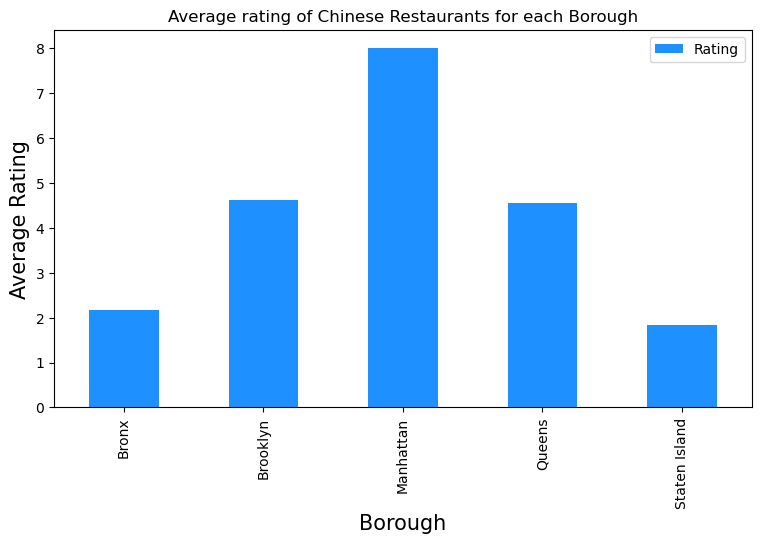

In [36]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Chinese Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
chinese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color="dodgerblue")
plt.legend()
plt.show()

In [37]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
8,Boerum Hill,8.300000
15,Chelsea,9.100000
16,Chinatown,8.390909
23,College Point,8.100000
32,East Village,9.100000
35,Elmhurst,8.250000
45,Greenwich Village,8.200000
57,Little Italy,8.550000
59,Long Island City,8.500000
60,Lower East Side,8.700000


In [38]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Boerum Hill,40.685683,-73.983748,8.300000
1,Manhattan,Chelsea,40.744035,-74.003116,9.100000
2,Staten Island,Chelsea,40.594726,-74.189560,9.100000
3,Manhattan,Chinatown,40.715618,-73.994279,8.390909
4,Queens,College Point,40.784903,-73.843045,8.100000
5,Manhattan,East Village,40.727847,-73.982226,9.100000
6,Queens,Elmhurst,40.744049,-73.881656,8.250000
7,Manhattan,Greenwich Village,40.726933,-73.999914,8.200000
8,Manhattan,Little Italy,40.719324,-73.997305,8.550000
9,Queens,Long Island City,40.750217,-73.939202,8.500000


In [44]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
rating = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, 
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [46]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
ny_map.add_child(rating)